In [110]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from statistics import mean
from scipy import stats

In [50]:
def loop_grid(matrix, mkd, a, width, height, neighbours):
    
    # protential grid
    transH = np.ones((width, height))
    transI = np.ones((width, height))
    transC = np.ones((width, height))
    
    list_distances = [1, 1.4, 2, 2.2, 2.8, 3, 3.2, 3.6, 4, 4.1, 4.2, 4.5, 5, 5.1, 5.4, 5.7, 5.8, 6, 6.1, 6.3, 6.4, 6.7, 7.1, 7.2, 7.8, 8.5]
    
    #i,j current house grid
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            # k,l is neighbourhood
            for k in range(i-(neighbours), i+(neighbours+1)):
                for l in range(j-(neighbours), j+(neighbours+1)):
                    
                    #only if neighboorhoud exists
#                   check if the neigbours are inside grid
                    if k < 0 or k > (width-1) or l < 0 or l > (height-1):
                        continue
            
                    else:
                        '''zoek op in dict:
                        ik ben zelf Matrix[i,j]
                        ik kijk naar Matrix[k,l]
                        ik kan worden loop [H, I, C] en update probabilitygrid
                        Eet een koekje
                        '''  
                    
#                       als degene waar je naar kijkt een huis is
                        if matrix[k, l] != 0 and (k, l) != (i, j) and matrix[i, j] != 3:
        
#                           op basis van hoe ver het huis van je vandaan zit krijg je een score uit de mkd
                            # Trans House potential
    
                            distance = round(np.sqrt((abs(i - k))**2 + (abs(l - j))**2), 1)
                            index_distance = list_distances.index(distance)
    
    
                            # kans op house worden, met wat we zelf zijn (matrix[i, j]) bepaald door plek waar we kijken en distance
#                             print(mkd[int(matrix[i, j])][1][int(matrix[k, l])][distance])
                            if matrix[i, j] != 2 and matrix[i, j] != 3:
                                transH[i, j] += mkd[int(matrix[i, j])][1][int(matrix[k, l])-1][index_distance]
            
                            # Trans Industry potential
                            if matrix[i, j] != 3:
                                transI[i, j] += mkd[int(matrix[i, j])][2][int(matrix[k, l])-1][index_distance]
                    
                            # Trans Commerce potential
                            transC[i, j] += mkd[int(matrix[i, j])][3][int(matrix[k, l])-1][index_distance]
                            
    for i in range(len(transH)):
        for j in range(len(transH[0])):
            S = 1 + (-np.log(random.random()))**(a)
            transH[i, j] *= S
            S = 1 + (-np.log(random.random()))**(a)
            transI[i, j] *= S
            S = 1 + (-np.log(random.random()))**(a)
            transC[i, j] *= S
            

    return transH, transI, transC

In [144]:
def simulate_growth(city, width, height, steps, Nh, a, mkd, n):
    citiesovertime = []

    for step in range(steps):
        transH, transI, transC = loop_grid(city, mkd, a, width, height, n)

        orderedhouses = transH.flatten().argsort()[::-1]
        orderedindustry = transI.flatten().argsort()[::-1]
        orderedcommerce = transC.flatten().argsort()[::-1]

        newhouses = orderedhouses[0:round((((width*height)*Nh)/12)*7)]
        for house in range(round((((width*height)*Nh)/12)*7)):
            orderedhouses = np.delete(orderedhouses, house)

        newindustry = orderedindustry[0:round((((width*height)*Nh)/12)*4)]
        for ind in range(round((((width*height)*Nh)/12)*4)):
            orderedindustry = np.delete(orderedindustry, ind)

        newcommerce = orderedcommerce[0:round(((width*height)*Nh)/12)]
        for com in range(round(((width*height)*Nh)/12)):
            orderedcommerce = np.delete(orderedcommerce, com)

        while len(set(newcommerce) & set(newindustry)) != 0:
            for doubleindex in (set(newcommerce) & set(newindustry)):
                if transI[doubleindex//width, doubleindex%height] > transC[doubleindex//width, doubleindex%height]:
                    newcommerce = np.delete(newcommerce, np.where(newcommerce == doubleindex)[0])
                    newcommerce = np.append(newcommerce, orderedcommerce[0])
                    orderedcommerce = np.delete(orderedcommerce, 0)
                else:
                    newindustry = np.delete(newindustry, np.where(newindustry == doubleindex)[0])
                    newindustry = np.append(newindustry, orderedindustry[0])
                    orderedindustry = np.delete(orderedindustry, 0)

        while len(set(newcommerce) & set(newhouses)) != 0:
            for doubleindex in (set(newcommerce) & set(newhouses)):
                if transH[doubleindex//width, doubleindex%height] > transC[doubleindex//width, doubleindex%height]:
                    newcommerce = np.delete(newcommerce, np.where(newcommerce == doubleindex)[0])
                    newcommerce = np.append(newcommerce, orderedcommerce[0])
                    orderedcommerce = np.delete(orderedcommerce, 0)
                else:
                    newhouses = np.delete(newhouses, np.where(newhouses == doubleindex)[0])
                    newhouses = np.append(newhouses, orderedhouses[0])
                    orderedhouses = np.delete(orderedhouses, 0)

        while len(set(newhouses) & set(newindustry)) != 0:
            for doubleindex in (set(newhouses) & set(newindustry)):
                if transI[doubleindex//width, doubleindex%height] > transH[doubleindex//width, doubleindex%height]:
                    newhouses = np.delete(newhouses, np.where(newhouses == doubleindex)[0])
                    newhouses = np.append(newhouses, orderedhouses[0])
                    orderedhouses = np.delete(orderedhouses, 0)
                else:
                    newindustry = np.delete(newindustry, np.where(newindustry == doubleindex)[0])
                    newindustry = np.append(newindustry, orderedindustry[0])
                    orderedindustry = np.delete(orderedindustry, 0)


        for com in newcommerce:
            city[com//width, com%height] = 3

        for indus in newindustry:
            if city[indus//width, indus%height] != 3:
                city[indus//width, indus%height] = 2

        for house in newhouses:
            if city[house//width, house%height] != 2 and city[house//width, house%height] != 3:
                city[house//width, house%height] = 1

        citiesovertime.append(copy.deepcopy(city))
        
#         plt.matshow(city, vmin = 0, vmax = 3, cmap = 'Greys')
#         plt.title("Step %i" %step)
#         plt.colorbar()
#         plt.show()
        
    return citiesovertime

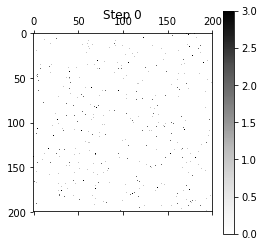

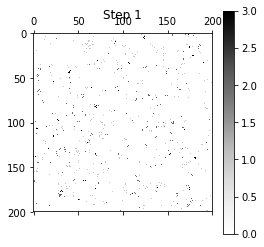

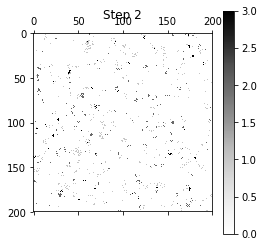

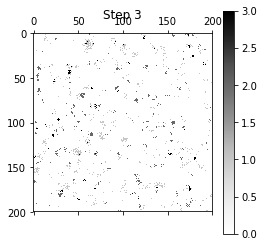

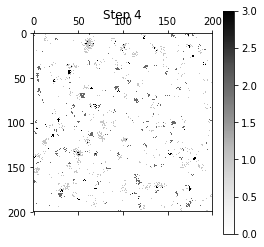

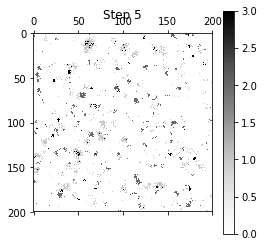

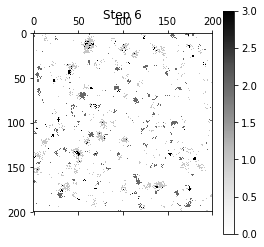

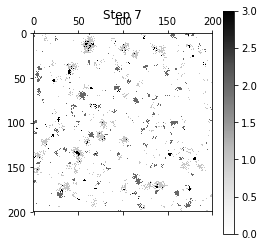

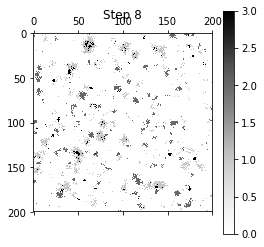

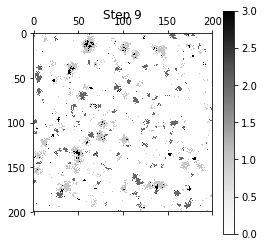

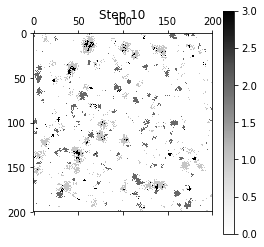

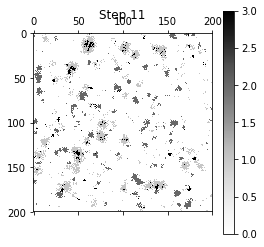

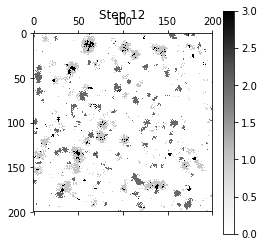

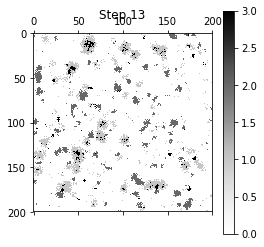

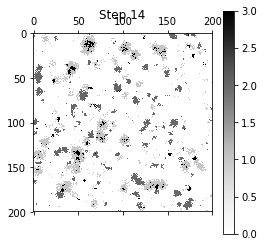

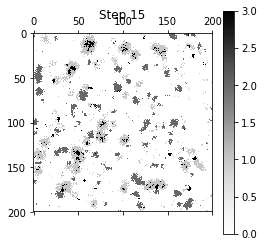

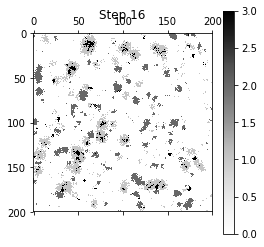

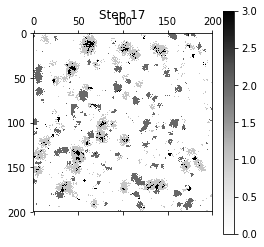

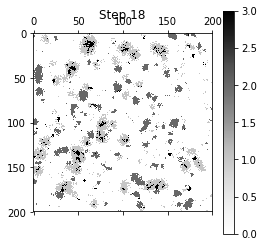

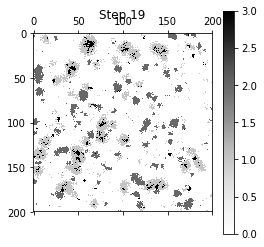

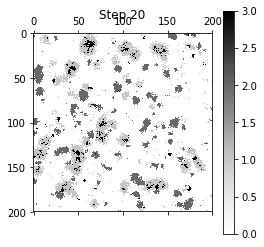

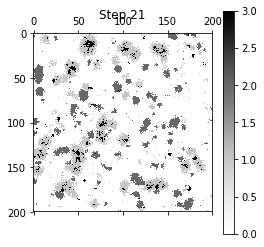

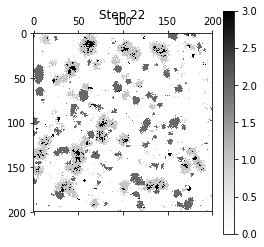

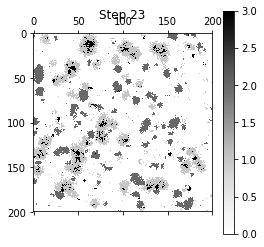

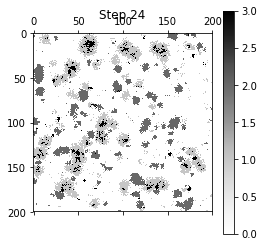

In [141]:
# V, H, I, C
# 0, 1, 2, 3

width = 200
height = 200

initialcity = np.zeros((width, height))

steps = 25

# initialcity[10, 10] = 1
# initialcity[190, 190] = 1
Nh = 0.01
a = 1.5
n = 4

mkd = {0: {1: [[2,2,1.5,1.5,1,1,1,1,0.5,0.5,0.5,0.5,0.5,0.1,0.1,0.1,0.1,0.1,0,0,0,0,0,0,0,0], 
               [-10,-10,-5,-3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [-2,-1,2,1,1,1,0.5,0.5,0.4,0.3,0.2,0.1,0.1,0.1,0,0,0,0,0,0,0,0,0,0,0,0]], 
           2: [[-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [3,3,2,1,0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           3: [[4,3.5,3,2.5,2,2,2,1.5,1.5,1.5,1.5,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [25,25,25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0]]}, 
       1: {1: [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           2: [[-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           3: [[4,3.5,3,2.5,2,2,2,1.5,1.5,1.5,1.5,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
               [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [25,25,25,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0]]},
       2: {1: [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           2: [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           3: [[4,3.5,3,2.5,2,2,2,1.5,1.5,1.5,1.5,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
               [-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [25,25,25,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0]]}}

citiesovertime = simulate_growth(initialcity, width, height, steps, Nh, a, mkd, n)



[[0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


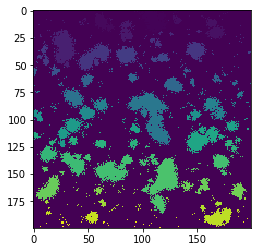

area: [869. 750. 464. 460. 440. 399. 318. 285. 271. 269. 263. 223. 223. 213.
 212. 197. 172. 161. 160. 160. 152. 129. 125. 121. 110.  95.  93.  93.
  90.  85.  83.  79.  69.  64.  63.  62.  53.  53.  49.  48.  48.  47.
  45.  45.  36.  35.  29.  28.  28.  27.  26.  24.  21.  21.]


C:\Users\tessa\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


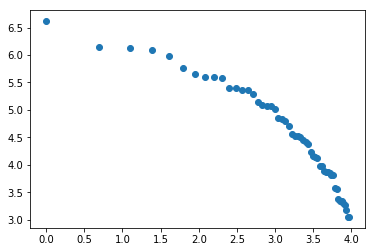

In [105]:
# from pylab import *
from scipy.ndimage import measurements

s = [[1,1,1],
    [1,1,1],
    [1,1,1]]

testM = copy.deepcopy(citiesovertime[(steps - 1)])
testM[testM == 3] = 1
testM[testM == 2] = 1
lw, num = measurements.label(testM, structure = s)
print(lw)

plt.imshow(lw)
plt.show()

area = measurements.sum(testM, lw, index=arange(lw.max() + 1))
area = -np.sort(-area[area > 20])

print("area:", area)

plt.scatter(log(range(0, len(area))), log(area))

# # plt.scatter(range(0, len(area)), sort(log(area)))
# # plt.scatter(sort(log(area)), log(range(len(area), 0, -1)))
# plt.scatter(range(len(area), 0, -1), sort(log(area)))
# plt.show()

# # plt.matshow(testM, vmin = 0, vmax = 3, cmap = 'Greys')
# # plt.colorbar()
plt.show()


In [ ]:
def size_distr(testM):
    s = [[1,1,1],
        [1,1,1],
        [1,1,1]]

#     testM = copy.deepcopy(citiesovertime[(steps - 1)])
    testM[testM == 3] = 1
    testM[testM == 2] = 1
    lw, num = measurements.label(testM, structure = s)
#     print(lw)

    clusterdict = {}

    for i in range(len(lw)):
        for j in range(len(lw[0])):
            if lw[i, j] in clusterdict:
                clusterdict[lw[i, j]].append(citiesovertime[(steps - 1)][i, j])
            else:
                clusterdict[lw[i, j]] = [citiesovertime[(steps - 1)][i, j]]

    removelist = []
    for key, value in clusterdict.items():
        if 1 in value:
    #         if 2 in value:
            if 3 in value:
                continue
            else:
                removelist.append(key)
    #         else:
    #             removelist.append(key)
        else:
            removelist.append(key)

    for key in removelist:
        clusterdict.pop(key, None)

    clustersizes = []
    for key, value in clusterdict.items():
        clustersizes.append(len(value))

#     print(clustersizes)

    plt.scatter(log(sort(clustersizes)), log(range(len(clustersizes))))

    # slope, intercept, r_value, p_value, std_err = stats.linregress(log(sort(clustersizes)), log(range(1, len(clustersizes)+1)))


    # print(slope, intercept, r_value, p_value, std_err)
    # plt.plot(log(range(0, len(area)))+2, log(range(0, len(area))) * slope)
    # print(clusterdict)
    # plt.imshow(citiesovertime[(steps - 1)])

steps = 25
sims = 1
for i in range(sims):
    citiesovertime = simulate_growth(initialcity, width, height, steps, Nh, a, mkd, n)
    m = copy.deepcopy(citiesovertime[(steps-1)])
    size_distr(m)
    
plt.show()

area: [910. 794. 496. 495. 474. 429. 341. 295. 290. 290. 276. 248. 233. 230.
 225. 210. 179. 168. 167. 164. 163. 133. 132. 124. 119. 101.  99.  97.
  95.  89.  89.  86.  74.  66.  65.  63.  58.  53.  51.  50.  49.  49.
  48.  47.  39.  38.  29.  28.  28.  27.  26.  24.  22.  21.  21.]
-1.0461351027765362 7.837528306408155 -0.9402768157618859 1.8182142722967865e-26 0.05202324482992398


C:\Users\tessa\Miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
C:\Users\tessa\Miniconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


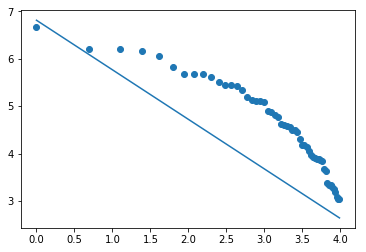

In [121]:
from scipy.ndimage import measurements

s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

testM = copy.deepcopy(citiesovertime[(steps - 1)])
testM[testM == 3] = 1
testM[testM == 2] = 1

for i in range(len(testM)):
    for j in range(len(testM[0])):
        if i > 0 and i < width-1 and j > 0 and j < height-1:
            nbsum = (testM[i-1,j-1] + testM[i-1,j] + testM[i-1,j+1] + testM[i,j-1] + testM[i,j+1] + testM[i+1,j-1] + testM[i+1,j] + testM[i+1,j+1])
            if nbsum > 5:
                testM[i, j] = 1

lw, num = measurements.label(testM, structure = s)

area = measurements.sum(testM, lw, index=arange(lw.max() + 1))
area = -np.sort(-area[area > 20])

slope, intercept, r_value, p_value, std_err = stats.linregress(log(range(1, len(area)+1)), log(area))


print("area:", area)

plt.scatter(log(range(0, len(area))), log(area))

print(slope, intercept, r_value, p_value, std_err)
plt.plot(log(range(0, len(area))), log(range(0, len(area))) * slope + log(area[0]))

plt.show()